In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [95]:
file_paths = [
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/peugeot_207_02.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/peugeot_207_01.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/opel_corsa_01.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/opel_corsa_02.csv',
    ]

# Function to get the columns of a CSV file
def get_columns(file_path):
    return pd.read_csv(file_path, delimiter=';', encoding='latin1', nrows=0)

# Dictionary to hold file paths and their respective columns
file_columns = {file_path: get_columns(file_path).columns.tolist() for file_path in file_paths}

In [96]:
# Extract the columns of the first file to use as a reference
reference_columns = file_columns[file_paths[0]]

# Function to compare two lists
def lists_match(list1, list2):
    return list1 == list2

# Check if all files have the same structure
all_match = all(lists_match(reference_columns, cols) for cols in file_columns.values())

print(f"All files have the same structure: {all_match}")


All files have the same structure: True


In [97]:
# concatenate all CSV files into a single DataFrame
def concatenate_csv_files(file_paths):
    dfs = []  # List to store DataFrames
    for file_path in file_paths:
        df = pd.read_csv(file_path, delimiter=';', encoding='latin1')  # Load each file into a DataFrame
        dfs.append(df)  # Append the DataFrame to the list
    combined_df = pd.concat(dfs, ignore_index=True)  # Concatenate all DataFrames
    return combined_df

# concatenate all your files
combined_df = concatenate_csv_files(file_paths)

#  inspect the combined DataFrame
print(combined_df.head())  # Print the first 5 rows of the combined dataframe

   Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
0          59          -0.599998                  24.299999   
1          60           0.099998                  27.900000   
2          61          -0.200001                  30.599998   
3          62          -0.899998                  29.699999   
4          63          -0.900002                  28.799999   

   VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
0             8.720689             46.843772               6.299999   
1             9.045762             52.270798               3.600000   
2             9.405000             59.127937               2.699999   
3             9.900000             64.360674              -0.900000   
4            10.380000             68.519589              -0.900000   

   LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
0                   -1.2903   67.058823                      26.0   
1                   -1.4038    0.000000                 

This method helps identify columns with missing values and gives you an insight into the datatypes of each column.


In [98]:
combined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23775 entries, 0 to 23774
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 23775 non-null  int64  
 1   AltitudeVariation          23775 non-null  float64
 2   VehicleSpeedInstantaneous  23766 non-null  float64
 3   VehicleSpeedAverage        23775 non-null  float64
 4   VehicleSpeedVariance       23775 non-null  float64
 5   VehicleSpeedVariation      23775 non-null  float64
 6   LongitudinalAcceleration   23775 non-null  float64
 7   EngineLoad                 23770 non-null  float64
 8   EngineCoolantTemperature   23770 non-null  float64
 9   ManifoldAbsolutePressure   23770 non-null  float64
 10  EngineRPM                  23770 non-null  float64
 11  MassAirFlow                23770 non-null  float64
 12  IntakeAirTemperature       23770 non-null  float64
 13  VerticalAcceleration       23775 non-null  flo

The .describe() method shows a quick statistic summary of your numerical data.

In [99]:
combined_df.describe()


,Unnamed: 0,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
count,23775.000000,23775.000000,23766.000000,23775.000000,23775.000000,23775.000000,23775.000000,23770.000000,23770.000000,23770.000000,23770.000000,23770.000000,23770.000000,23775.000000,23770.000000
mean,3410.669106,-0.263008,38.644538,38.811064,171.920888,-0.020554,0.681683,36.762356,70.818721,115.195120,1486.820257,16.045632,23.483004,0.463398,15.171096
std,2196.419996,2.091264,33.864438,31.149198,182.751192,2.475485,1.582911,26.640593,15.685020,20.455268,578.064539,9.692254,10.902487,3.462745,4.603774
min,44.000000,-24.600006,0.000000,0.000000,0.000000,-103.500000,-3.065000,0.000000,12.000000,88.000000,0.000000,0.880000,7.000000,-2.763100,7.271883
25%,1608.000000,-1.399996,11.700000,15.991532,46.048954,-0.900001,-0.219000,18.823530,63.000000,102.000000,854.000000,6.970000,16.000000,-0.554000,11.672288
50%,3150.000000,-0.099998,31.500000,29.314682,113.907731,0.000000,0.391000,31.372549,79.000000,107.000000,1485.000000,15.360000,19.000000,-0.078100,14.520122
75%,4906.500000,0.700001,54.899998,50.148162,230.200656,0.900002,1.159700,58.431374,81.000000,120.000000,1955.875000,21.717499,31.000000,0.237250,18.288337
max,8613.000000,11.400002,124.749725,121.330733,1418.370369,97.199997,8.477800,100.000000,89.000000,252.000000,3167.000000,73.250000,65.000000,17.944800,45.336861


In [100]:
print(combined_df['Unnamed: 0'].head())


0    59
1    60
2    61
3    62
4    63
Name: Unnamed: 0, dtype: int64


In [101]:
combined_df['drivingStyle'].value_counts()

drivingStyle
EvenPaceStyle      21016
AggressiveStyle     2759
Name: count, dtype: int64

drop rows with any missing values:

In [102]:
def check_first_index(file_path):
    df_temp = pd.read_csv(file_path, delimiter=';', encoding='latin1', nrows=1)
    first_index = df_temp.iloc[0]['Unnamed: 0']
    return first_index


In [103]:
file_paths = [
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/peugeot_207_02.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/peugeot_207_01.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/opel_corsa_01.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/opel_corsa_02.csv',
]

# Check and print the first index of each file
for file_path in file_paths:
    first_index = check_first_index(file_path)
    print(f"First index in {file_path.split('/')[-1]}: {first_index}")


First index in peugeot_207_02.csv: 59
First index in peugeot_207_01.csv: 59
First index in opel_corsa_01.csv: 59
First index in opel_corsa_02.csv: 44


In [104]:
is_unique = combined_df['Unnamed: 0'].is_unique
print(f"'Unnamed: 0' column is unique: {is_unique}")


'Unnamed: 0' column is unique: False


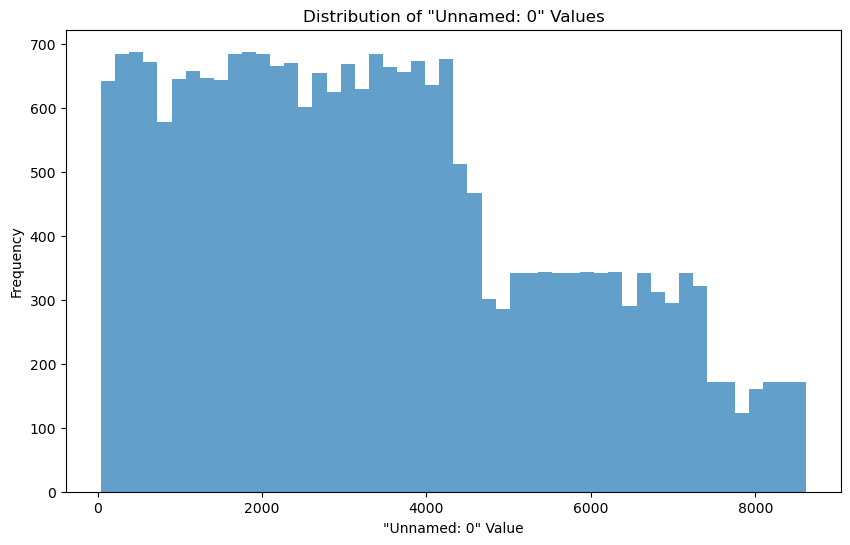

In [105]:
# Example: Plotting the distribution of 'Unnamed: 0' values
plt.figure(figsize=(10, 6))
plt.hist(combined_df['Unnamed: 0'], bins=50, alpha=0.7)
plt.title('Distribution of "Unnamed: 0" Values')
plt.xlabel('"Unnamed: 0" Value')
plt.ylabel('Frequency')
plt.show()


In [106]:
numeric_df = combined_df.select_dtypes(include=[np.number])  # This selects only the numeric columns
correlation_matrix = numeric_df.corr()
print(correlation_matrix['Unnamed: 0'])


Unnamed: 0                   1.000000
AltitudeVariation           -0.057173
VehicleSpeedInstantaneous    0.182689
VehicleSpeedAverage          0.199651
VehicleSpeedVariance         0.014199
VehicleSpeedVariation       -0.006077
LongitudinalAcceleration    -0.135014
EngineLoad                   0.050028
EngineCoolantTemperature     0.099476
ManifoldAbsolutePressure     0.096873
EngineRPM                    0.138630
MassAirFlow                  0.131978
IntakeAirTemperature         0.175893
VerticalAcceleration        -0.236292
FuelConsumptionAverage      -0.229560
Name: Unnamed: 0, dtype: float64


In [107]:
from scipy.stats import chi2_contingency

# Assuming 'roadSurface' is a categorical variable
contingency_table = pd.crosstab(combined_df['Unnamed: 0'], combined_df['drivingStyle'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared test statistic: {chi2}")
print(f"P-value: {p}")


Chi-squared test statistic: 7539.629739312686
P-value: 0.9999999999999949


In [108]:
# Calculate the percentage of missing values for each column
missing_percentages = combined_df.isnull().mean() * 100

# Display the percentage of missing values for each column
print(missing_percentages)

# Set a threshold for acceptable missing percentage
threshold = 5  # For example, 5%

# Find columns with a missing percentage above the threshold
columns_to_consider = missing_percentages[missing_percentages > threshold].index.tolist()

# Decide action based on the columns found
if columns_to_consider:
    print(f"Columns with more than {threshold}% missing values:", columns_to_consider)
    # You might drop these columns, or consider imputing their missing values
else:
    print(f"No columns have more than {threshold}% missing values.")


Unnamed: 0                   0.000000
AltitudeVariation            0.000000
VehicleSpeedInstantaneous    0.037855
VehicleSpeedAverage          0.000000
VehicleSpeedVariance         0.000000
VehicleSpeedVariation        0.000000
LongitudinalAcceleration     0.000000
EngineLoad                   0.021030
EngineCoolantTemperature     0.021030
ManifoldAbsolutePressure     0.021030
EngineRPM                    0.021030
MassAirFlow                  0.021030
IntakeAirTemperature         0.021030
VerticalAcceleration         0.000000
FuelConsumptionAverage       0.021030
roadSurface                  0.000000
traffic                      0.000000
drivingStyle                 0.000000
dtype: float64
No columns have more than 5% missing values.


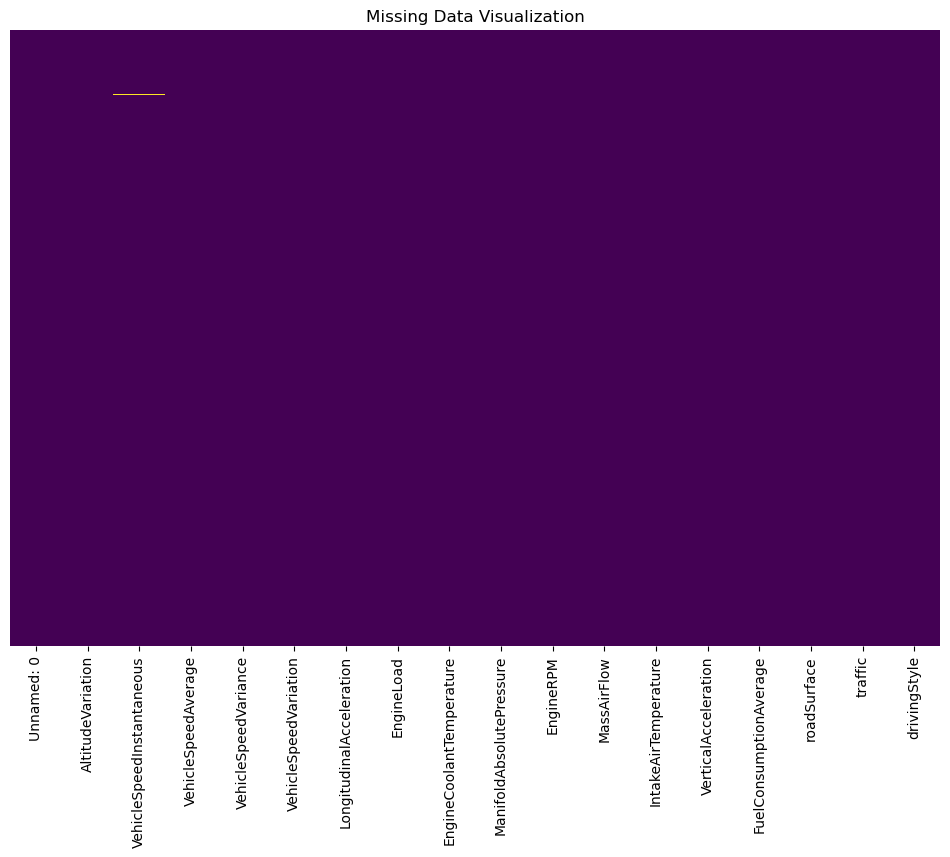

In [109]:
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Visualization')
plt.show()


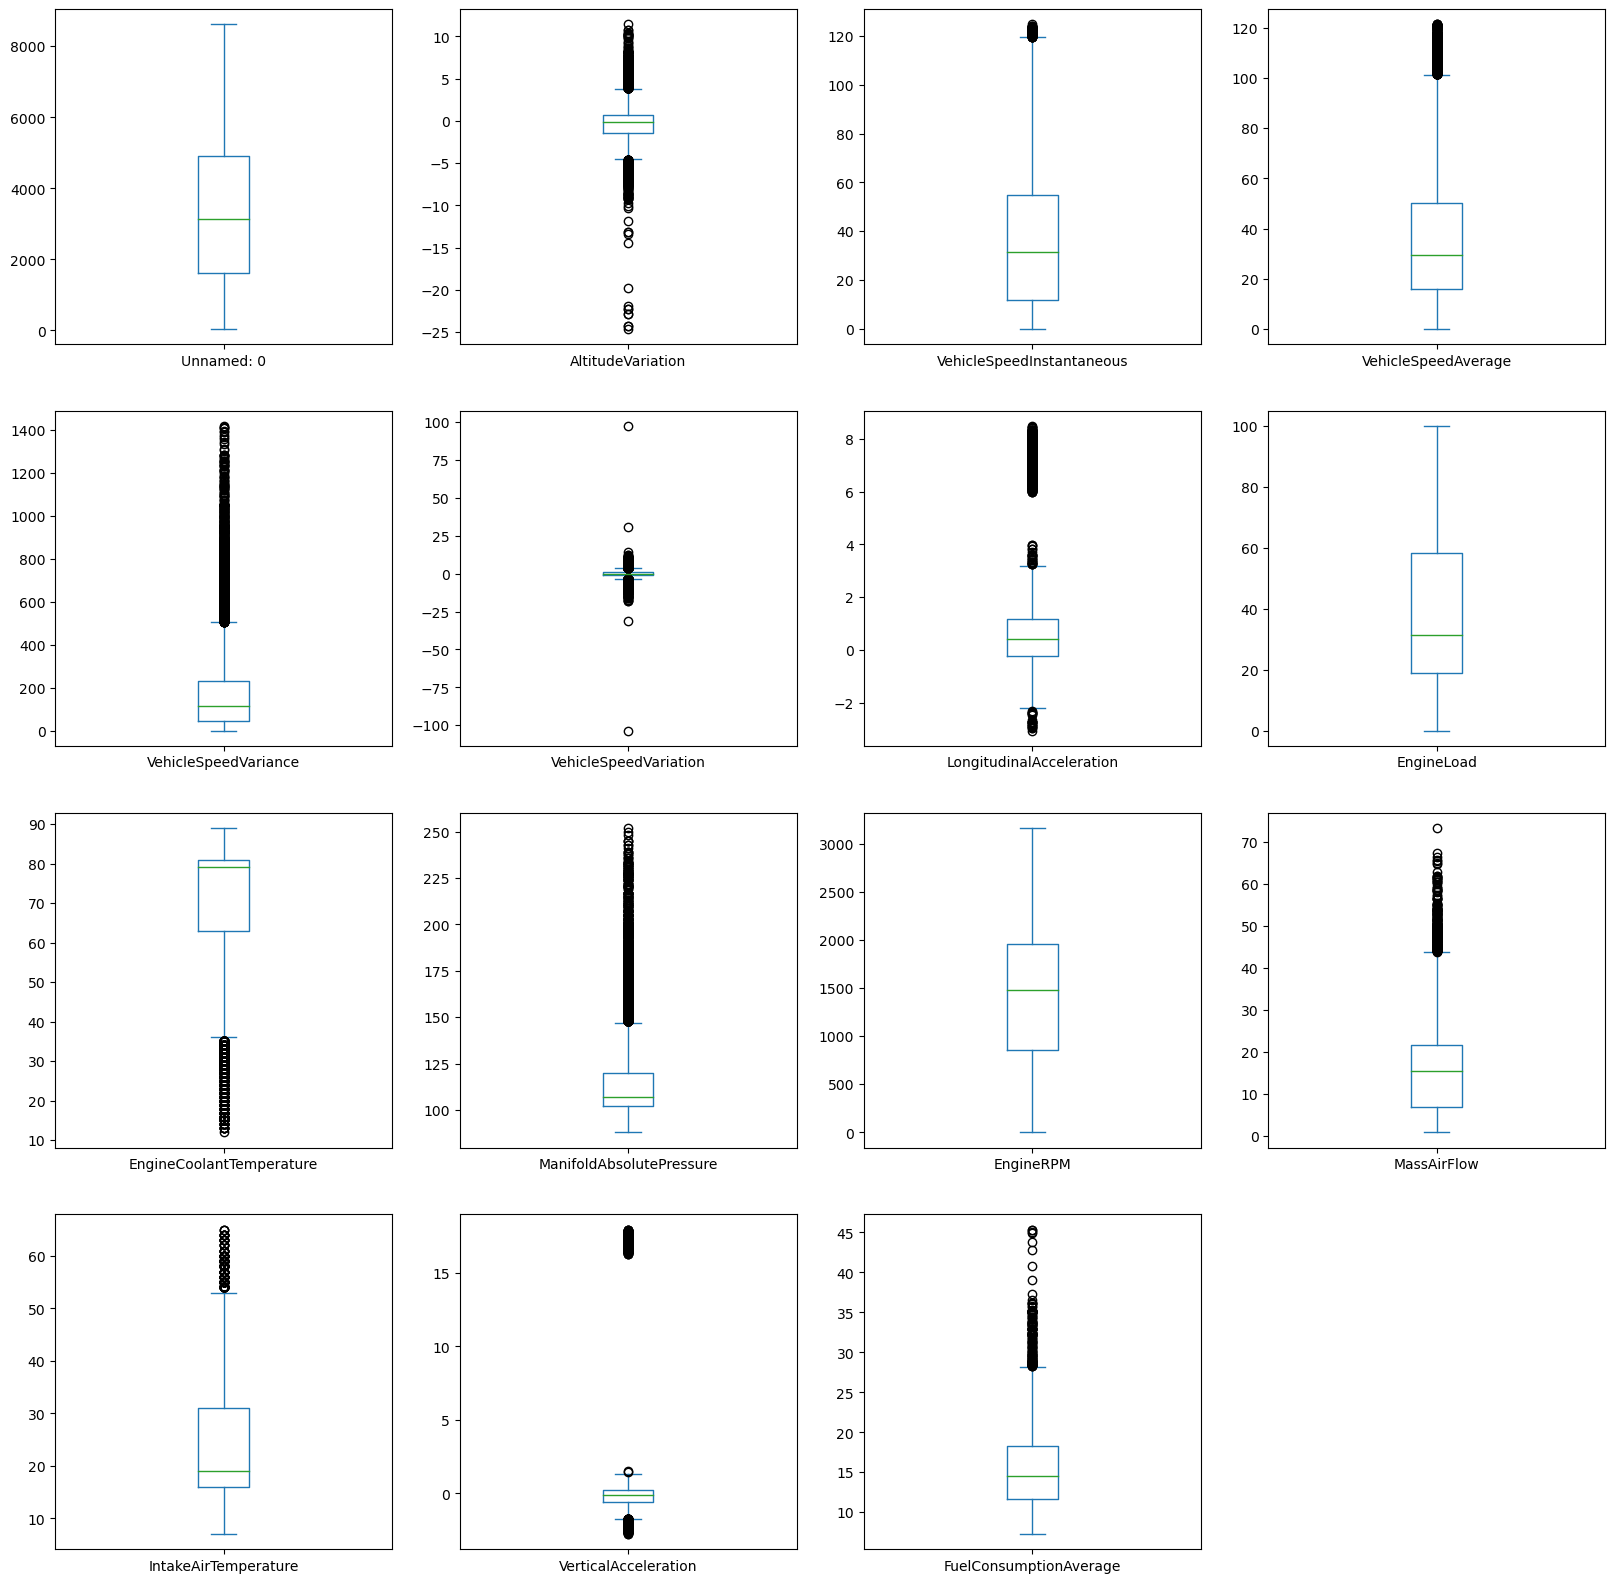

In [110]:
# Box plot for each numerical attribute
numerical_columns = combined_df.select_dtypes(include=[np.number]).columns.tolist()
combined_df[numerical_columns].plot(kind='box', subplots=True, layout=(4,4), figsize=(20, 20))
plt.show()


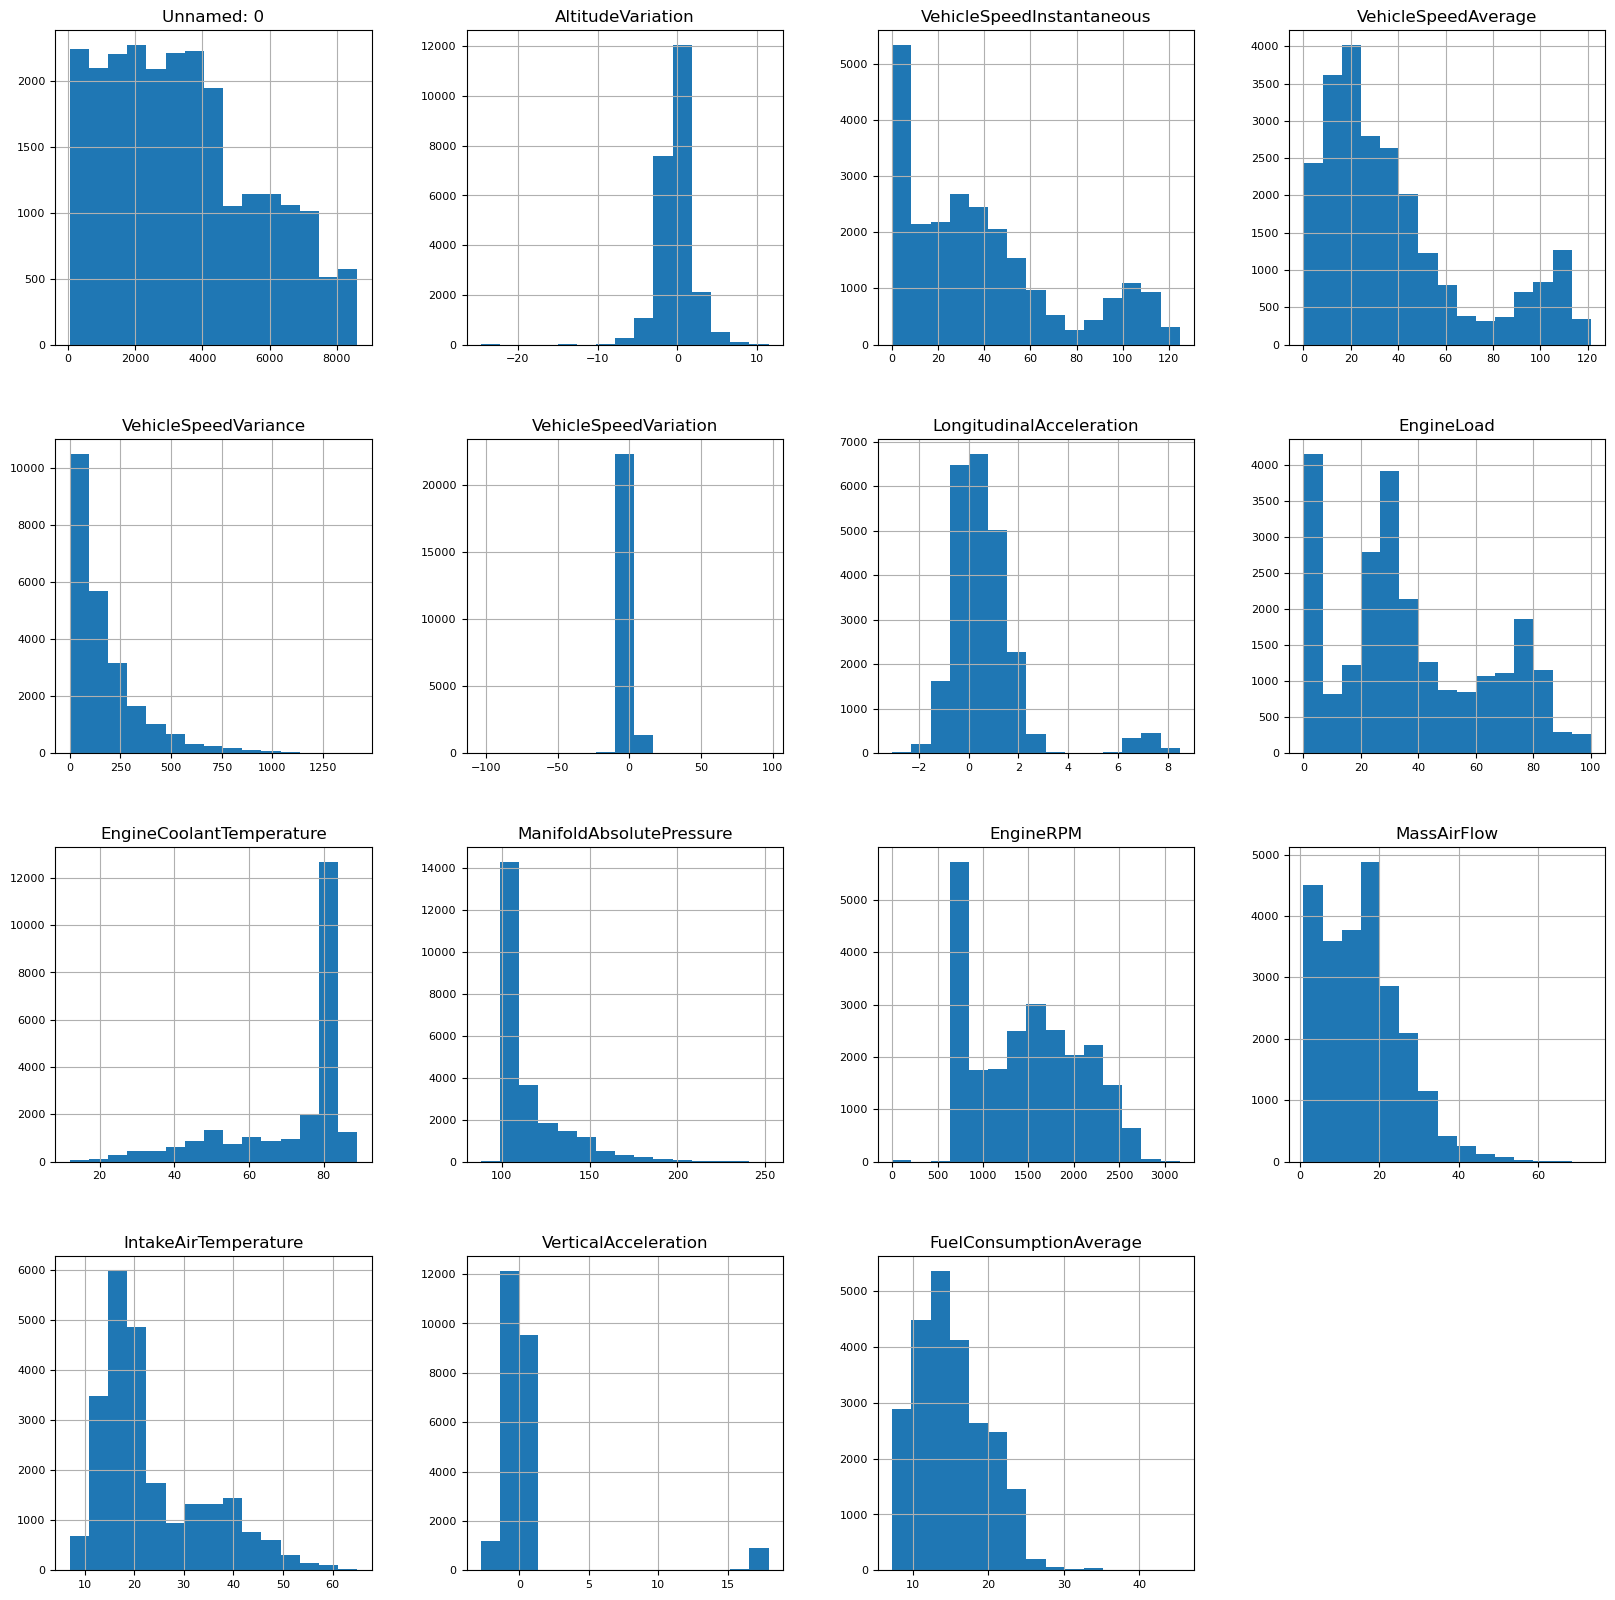

In [111]:
# Histograms for numerical columns
combined_df[numerical_columns].hist(bins=15, figsize=(20, 20), layout=(4, 4), xlabelsize=8, ylabelsize=8)
plt.show()


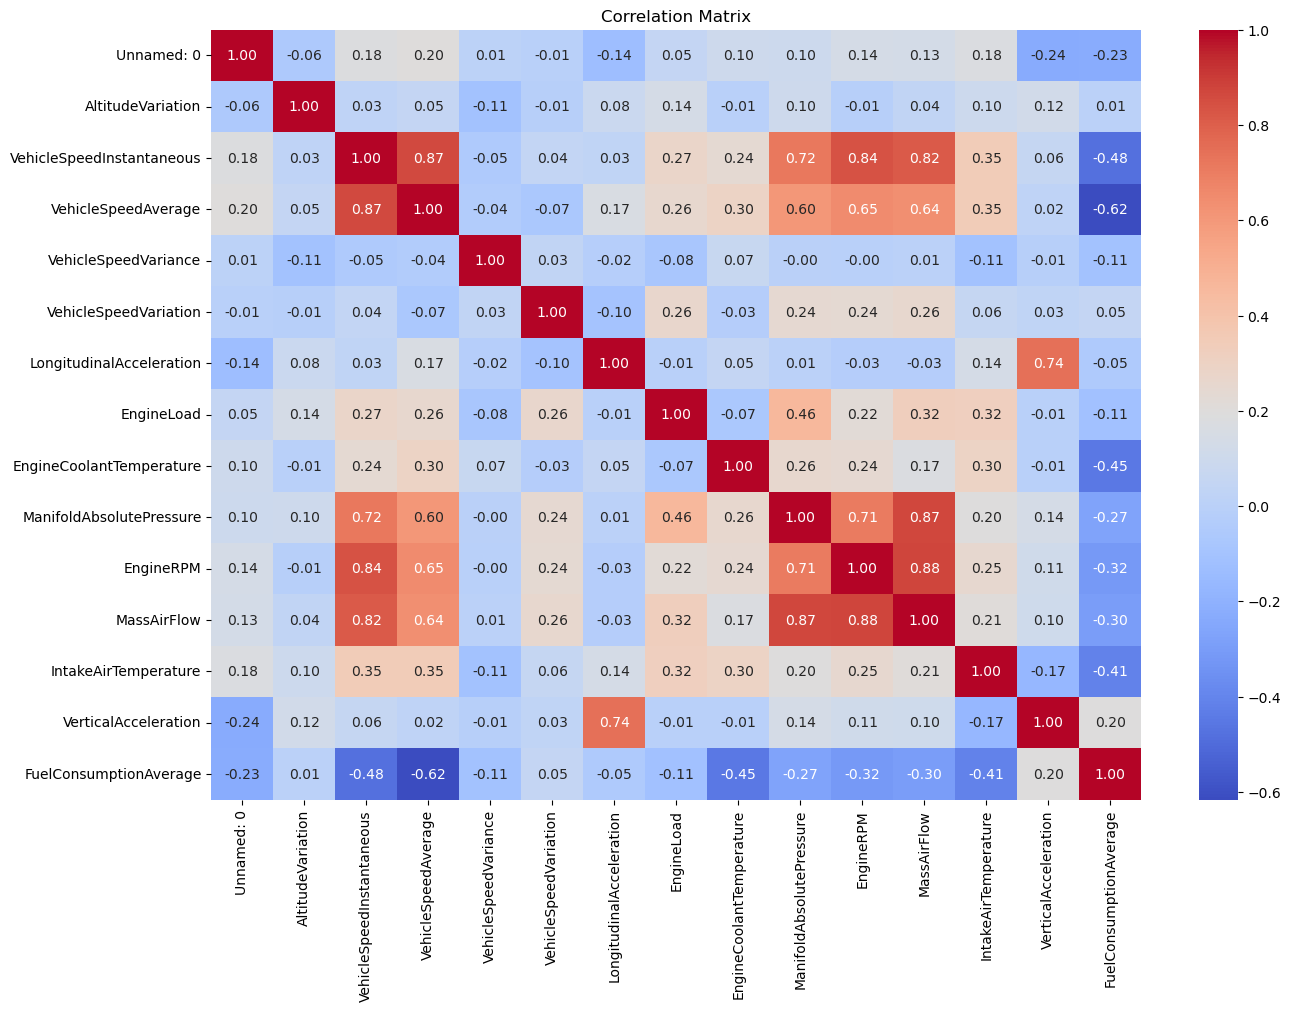

In [112]:
# Select only the numerical columns for the correlation matrix
numerical_df = combined_df.select_dtypes(include=[np.number])

plt.figure(figsize=(15, 10))
# Compute and plot the correlation matrix
sns.heatmap(numerical_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


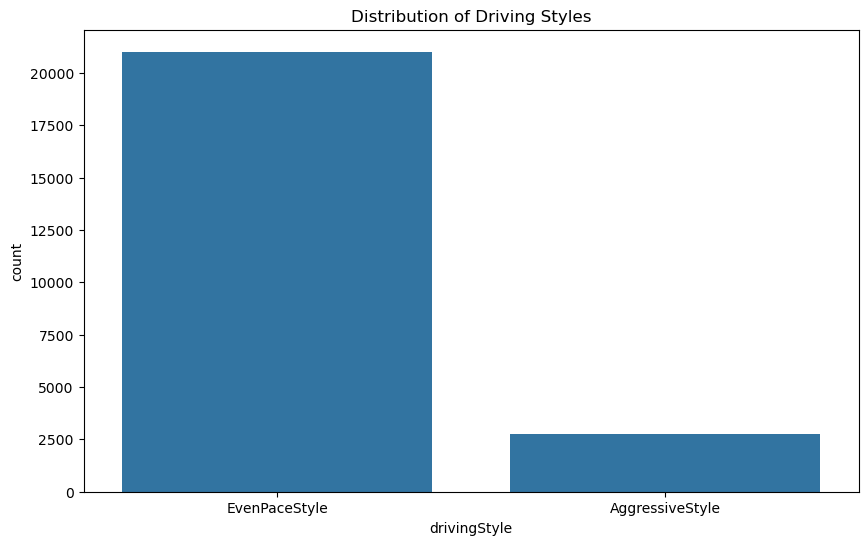

In [113]:
# Example: Count plot for drivingStyle
plt.figure(figsize=(10, 6))
sns.countplot(x='drivingStyle', data=combined_df)
plt.title('Distribution of Driving Styles')
plt.show()


In [114]:
print(f"Number of duplicate records: {combined_df.duplicated().sum()}")

Number of duplicate records: 0


In [115]:
# Assuming 'combined_df' is your pandas DataFrame
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['roadSurface', 'traffic', 'drivingStyle'], dtype='object')


c:\Users\daral\miniconda3\envs\qiskit-env\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


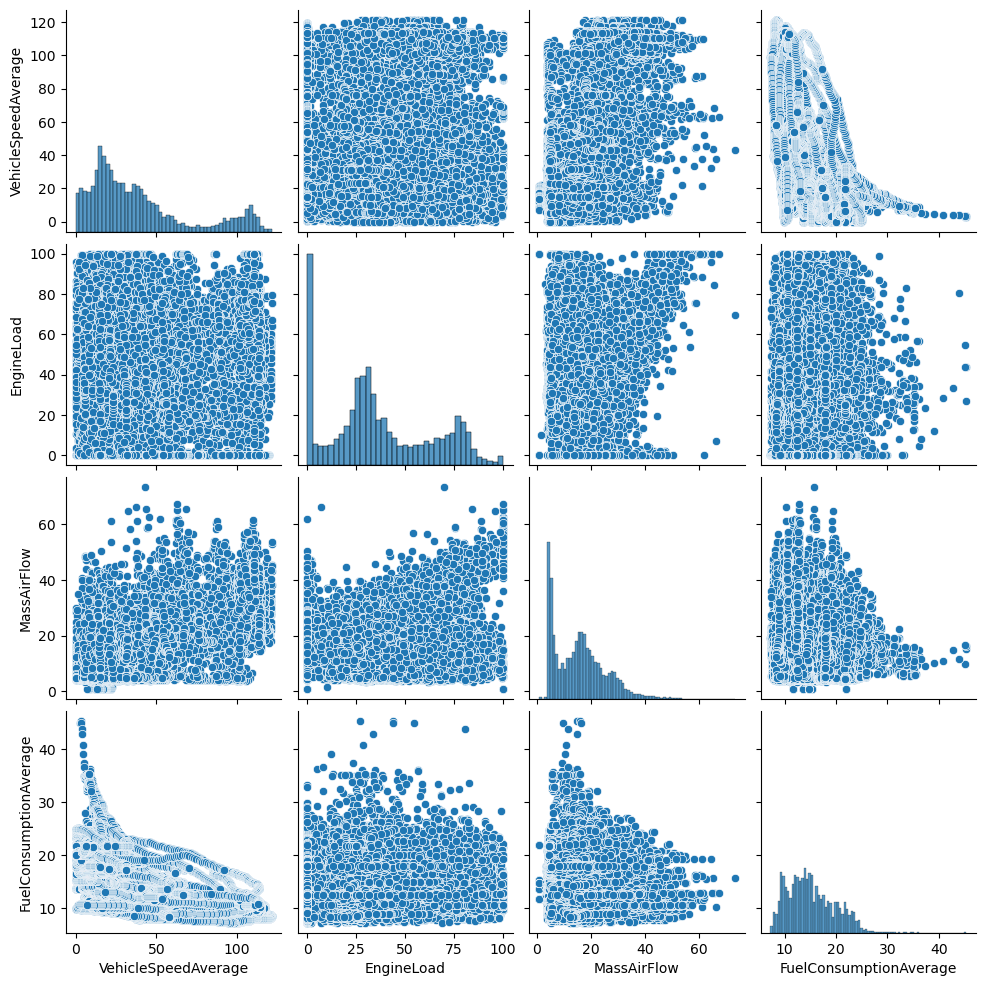

In [116]:
# Select a subset of numerical columns if there are too many to plot all at once
# Here's an example using hypothetical column names. Replace these with your actual column names.
selected_columns = ['VehicleSpeedAverage', 'EngineLoad', 'MassAirFlow', 'FuelConsumptionAverage']

# Now plot the pairplot using seaborn
sns.pairplot(combined_df[selected_columns])
plt.show()

In [117]:
from scipy.stats import chi2_contingency

# Cross-tabulate the two variables
contingency_table = pd.crosstab(combined_df['drivingStyle'], combined_df['roadSurface'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-squared test statistic: {chi2}")
print(f"P-value: {p}")


Chi-squared test statistic: 536.8466742302618
P-value: 2.6621092645635954e-117


In [118]:
combined_df.drop('Unnamed: 0', axis=1, inplace=True)


fill missing values with the median of the column:

In [120]:
# Impute missing values for numerical columns with the mean
numerical_columns = combined_df.select_dtypes(include=[np.number]).columns
for column in numerical_columns:
    combined_df[column].fillna(combined_df[column].mean(), inplace=True)

# Impute missing values for categorical columns with the mode
categorical_columns = combined_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    combined_df[column].fillna(combined_df[column].mode()[0], inplace=True)


In [122]:
print(combined_df.isnull().sum())


AltitudeVariation            0
VehicleSpeedInstantaneous    0
VehicleSpeedAverage          0
VehicleSpeedVariance         0
VehicleSpeedVariation        0
LongitudinalAcceleration     0
EngineLoad                   0
EngineCoolantTemperature     0
ManifoldAbsolutePressure     0
EngineRPM                    0
MassAirFlow                  0
IntakeAirTemperature         0
VerticalAcceleration         0
FuelConsumptionAverage       0
roadSurface                  0
traffic                      0
drivingStyle                 0
dtype: int64


In [123]:
print(combined_df.describe())

       AltitudeVariation  VehicleSpeedInstantaneous  VehicleSpeedAverage  \
count       23775.000000               23775.000000         23775.000000   
mean           -0.263008                  38.644538            38.811064   
std             2.091264                  33.858027            31.149198   
min           -24.600006                   0.000000             0.000000   
25%            -1.399996                  11.700000            15.991532   
50%            -0.099998                  31.500000            29.314682   
75%             0.700001                  54.899998            50.148162   
max            11.400002                 124.749725           121.330733   

       VehicleSpeedVariance  VehicleSpeedVariation  LongitudinalAcceleration  \
count          23775.000000           23775.000000              23775.000000   
mean             171.920888              -0.020554                  0.681683   
std              182.751192               2.475485                  1.58291

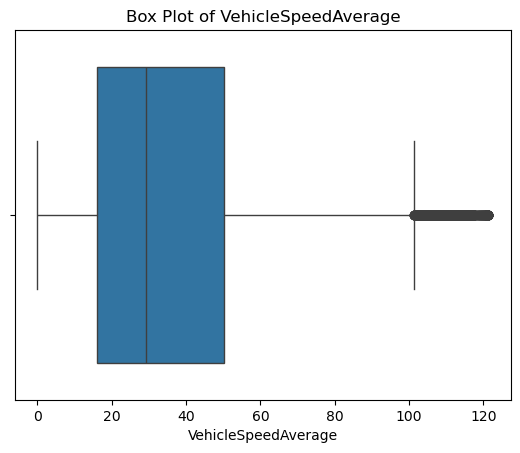

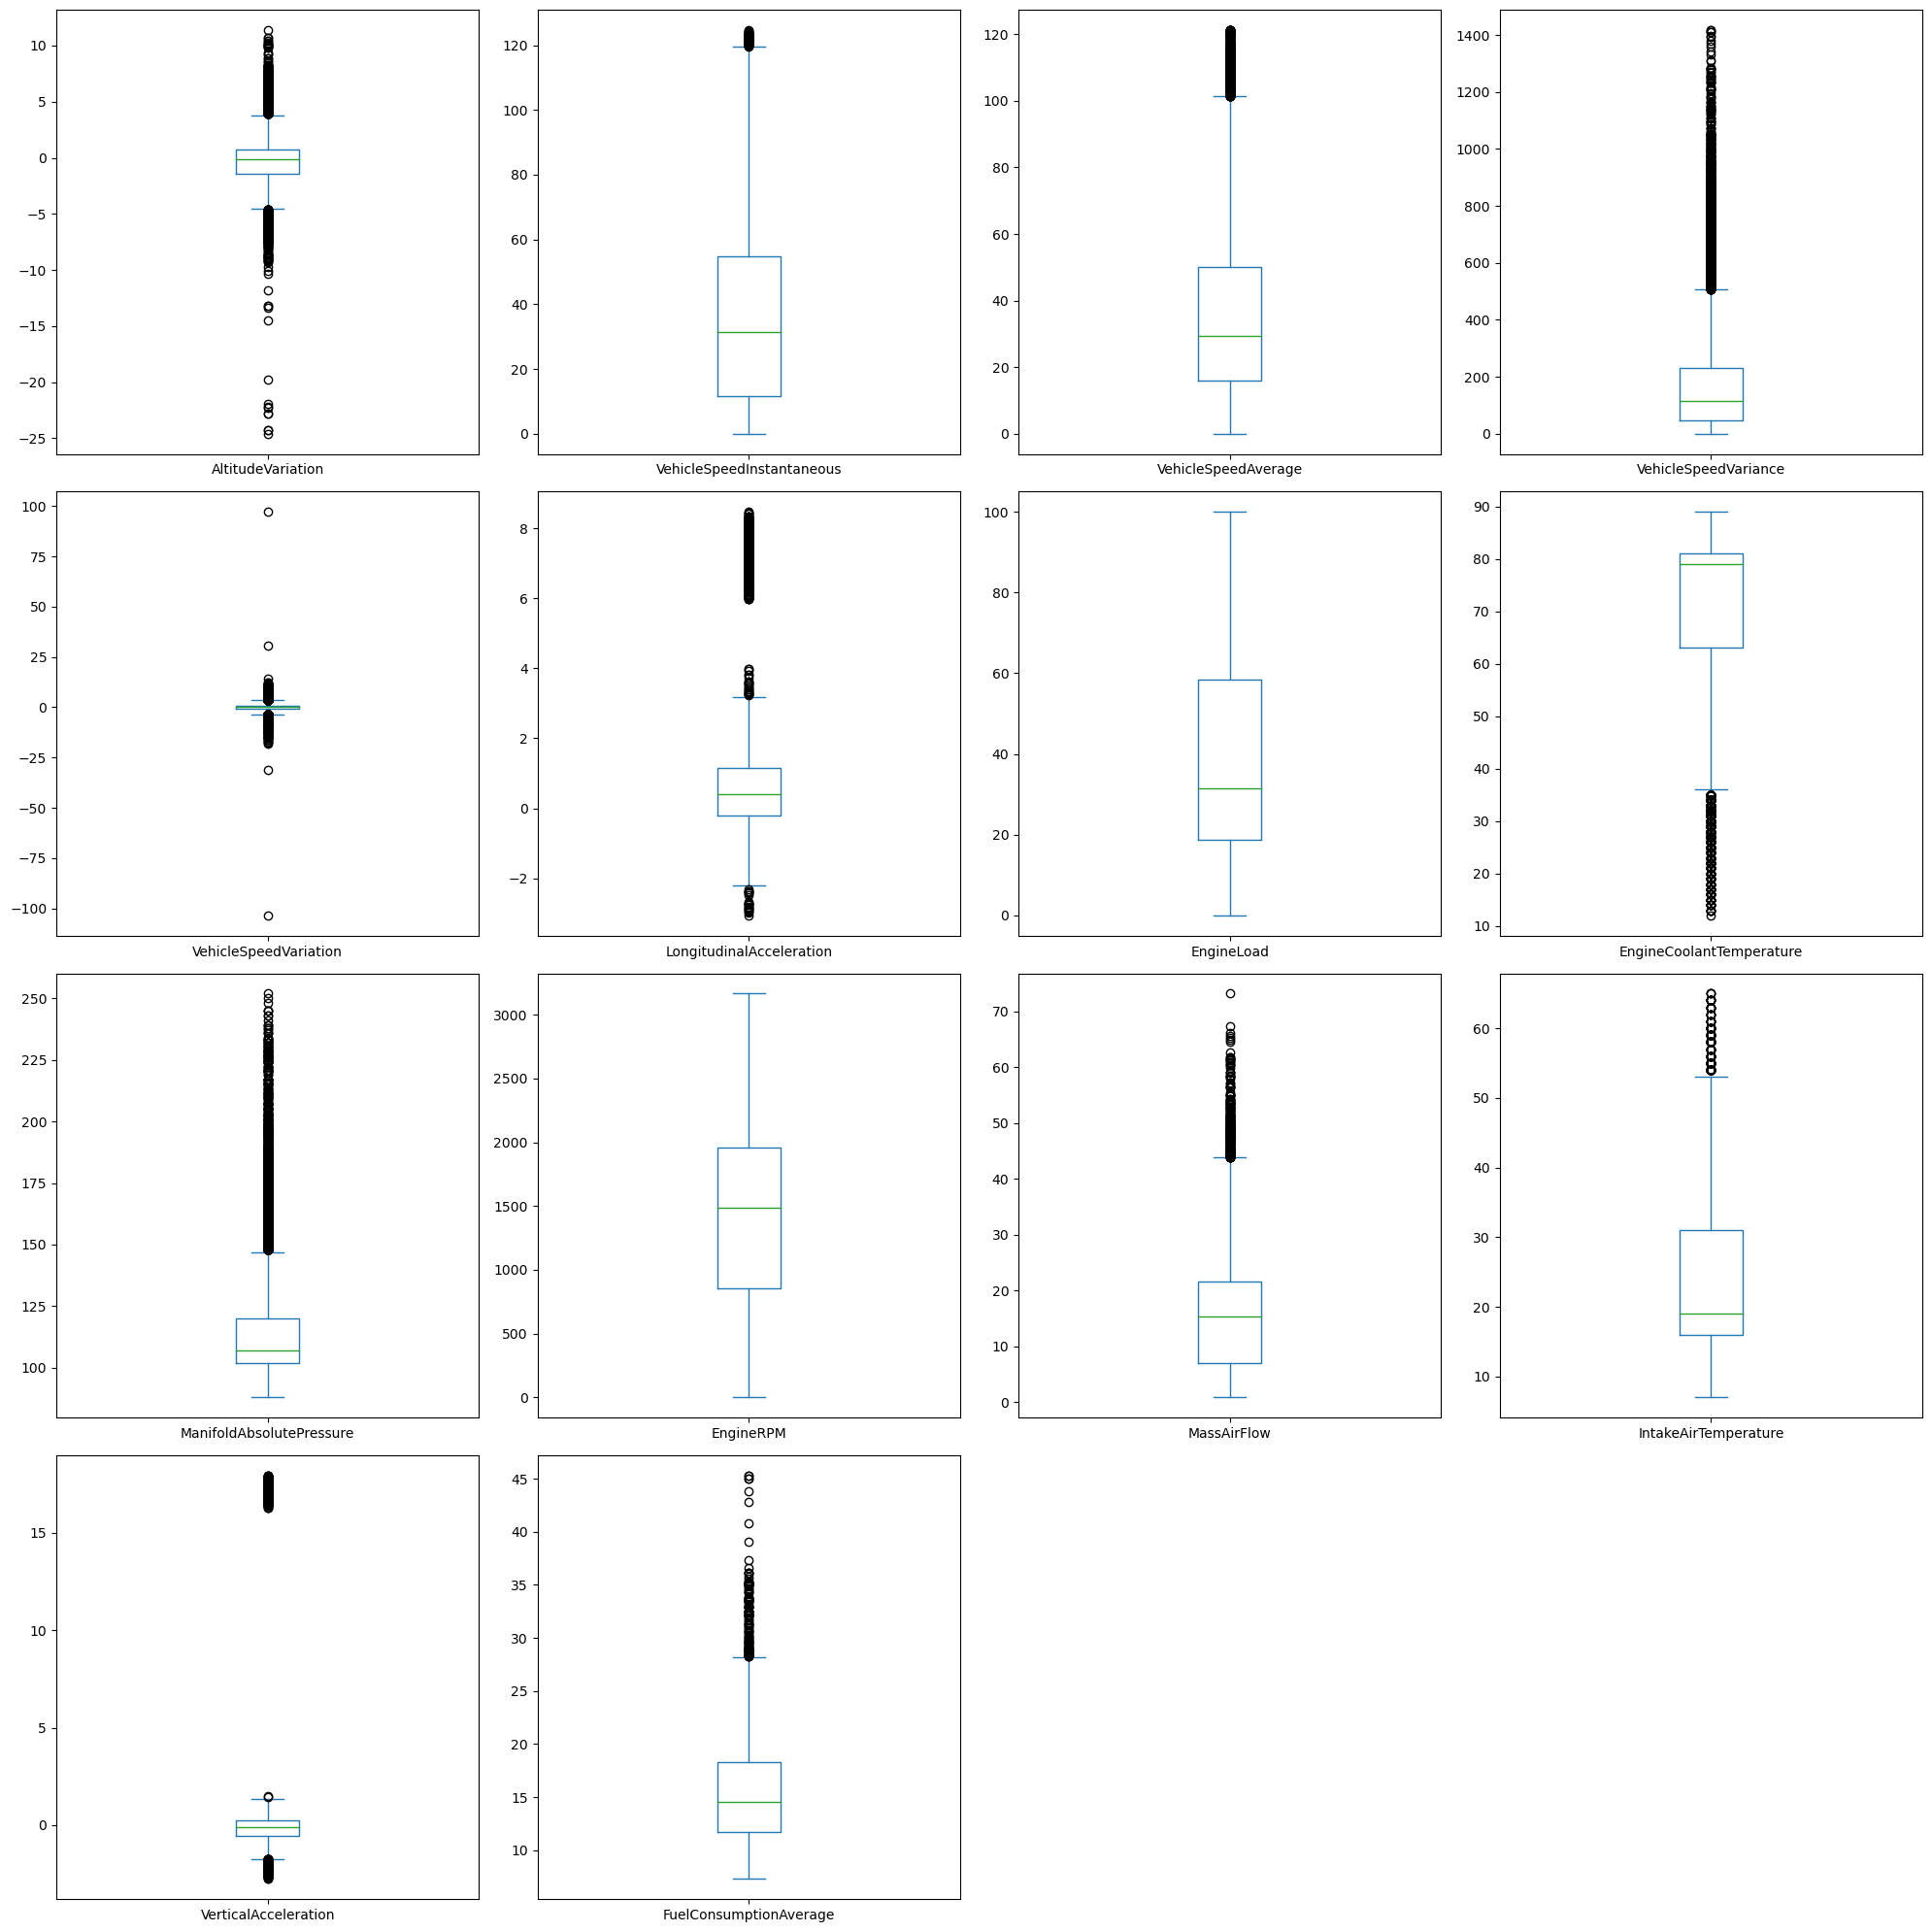

In [124]:
# For a single column
sns.boxplot(x=combined_df['VehicleSpeedAverage'])
plt.title('Box Plot of VehicleSpeedAverage')
plt.show()

# For all numerical columns
numerical_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
combined_df[numerical_columns].plot(kind='box', subplots=True, layout=(4, 4), figsize=(20, 20))
plt.tight_layout()
plt.show()

In [129]:
# Example for 'VehicleSpeedAverage'
z_scores = stats.zscore(combined_df['VehicleSpeedAverage'])
outliers = np.abs(z_scores) > 3
print("Outliers based on Z-scores:", combined_df['VehicleSpeedAverage'][outliers])

Outliers based on Z-scores: Series([], Name: VehicleSpeedAverage, dtype: float64)


In [130]:
# Assuming combined_df is your dataframe
for column in combined_df.select_dtypes(include=[np.number]).columns:
    if column != 'Unnamed: 0':  # Excluding identifier column
        z_scores = stats.zscore(combined_df[column])
        outliers = combined_df[column][np.abs(z_scores) > 3]
        print(f"Outliers in {column} based on Z-scores:")
        print(outliers)

Outliers in AltitudeVariation based on Z-scores:
66      -7.399998
67      -7.400002
68      -6.899998
499     -7.000000
500     -7.600002
           ...   
22791    7.599976
22792    7.299988
22793    7.799988
22794    7.400024
22795    6.299988
Name: AltitudeVariation, Length: 342, dtype: float64
Outliers in VehicleSpeedInstantaneous based on Z-scores:
Series([], Name: VehicleSpeedInstantaneous, dtype: float64)
Outliers in VehicleSpeedAverage based on Z-scores:
Series([], Name: VehicleSpeedAverage, dtype: float64)
Outliers in VehicleSpeedVariance based on Z-scores:
975      748.261263
976      730.808514
1022     757.030544
1023     745.262893
1024     729.771299
            ...    
23578    951.023355
23579    936.063059
23580    914.439217
23581    892.556145
23582    873.454347
Name: VehicleSpeedVariance, Length: 558, dtype: float64
Outliers in VehicleSpeedVariation based on Z-scores:
357      -8.099998
358      -9.000001
392     -10.799999
676     -15.299999
677     -17.099998
  

In [131]:
# Assuming 'combined_df' is your main DataFrame and 'outliers' are from one of the numerical columns
combined_df['IsOutlier'] = 0  # Initialize the flag column
combined_df.loc[outliers.index, 'IsOutlier'] = 1  # Flag outliers

In [132]:
# Example for 'roadSurface'
outliers_roadSurface = pd.crosstab(index=combined_df['IsOutlier'], columns=combined_df['roadSurface'], normalize='columns')
print(outliers_roadSurface)


roadSurface  FullOfHolesCondition  SmoothCondition  UnevenCondition
IsOutlier                                                          
0                             1.0         0.992765         0.998887
1                             0.0         0.007235         0.001113


In [133]:
from scipy.stats import chi2_contingency

# Example for 'roadSurface'
chi2, p, dof, expected = chi2_contingency(pd.crosstab(index=combined_df['IsOutlier'], columns=combined_df['roadSurface']))
print(f"Chi-squared test for 'roadSurface' and outliers: {chi2}, p-value: {p}")


Chi-squared test for 'roadSurface' and outliers: 52.98771706617897, p-value: 3.117908993778578e-12


In [134]:
from scipy.stats import chi2_contingency

# Example for 'traffic'
chi2, p, dof, expected = chi2_contingency(pd.crosstab(index=combined_df['IsOutlier'], columns=combined_df['traffic']))
print(f"Chi-squared test for 'traffic' and outliers: {chi2}, p-value: {p}")


Chi-squared test for 'traffic' and outliers: 22.723198943293184, p-value: 1.1633758490312654e-05


In [135]:
from scipy.stats import chi2_contingency

# Example for 'drivingStyle'
chi2, p, dof, expected = chi2_contingency(pd.crosstab(index=combined_df['IsOutlier'], columns=combined_df['drivingStyle']))
print(f"Chi-squared test for 'drivingStyle' and outliers: {chi2}, p-value: {p}")


Chi-squared test for 'drivingStyle' and outliers: 1.6196340408798668, p-value: 0.20314282290004892


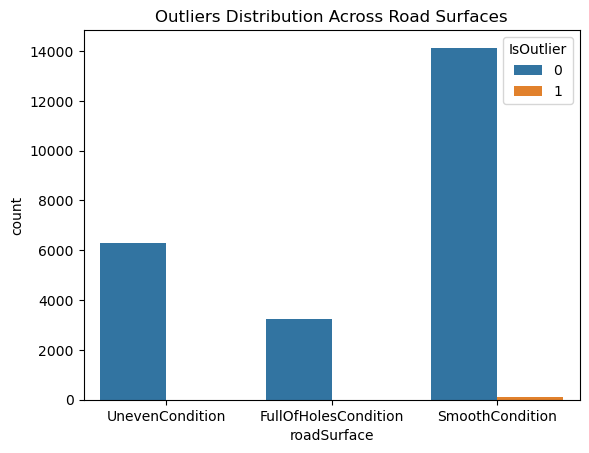

In [137]:
# Example visualization for 'roadSurface'
sns.countplot(x='roadSurface', hue='IsOutlier', data=combined_df)
plt.title('Outliers Distribution Across Road Surfaces')
plt.show()

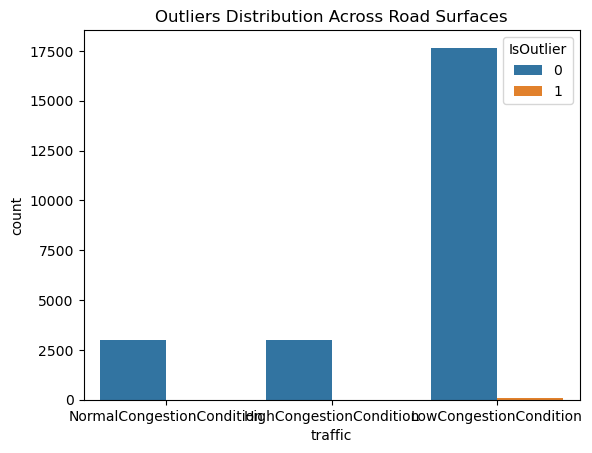

In [138]:
# Example visualization for 'traffc'
sns.countplot(x='traffic', hue='IsOutlier', data=combined_df)
plt.title('Outliers Distribution Across Road Surfaces')
plt.show()

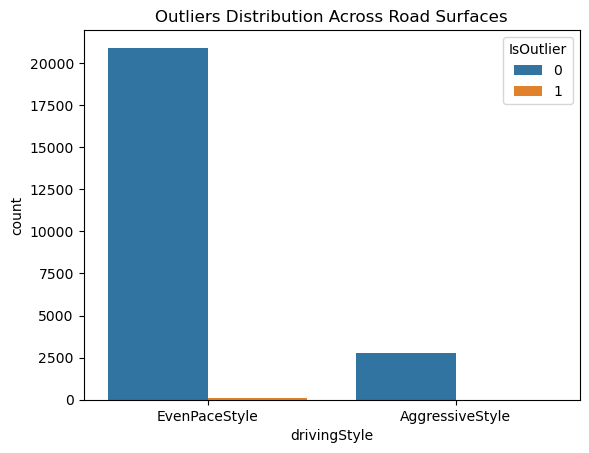

In [139]:
# Example visualization for 'drivingStyle'
sns.countplot(x='drivingStyle', hue='IsOutlier', data=combined_df)
plt.title('Outliers Distribution Across Road Surfaces')
plt.show()

In [142]:
# Replace 'target_variable' with your actual target variable column name
class_distribution = combined_df['drivingStyle'].value_counts(normalize=True)
print(class_distribution)
class_distribution = combined_df['traffic'].value_counts(normalize=True)
print(class_distribution)
class_distribution = combined_df['roadSurface'].value_counts(normalize=True)
print(class_distribution)


drivingStyle
EvenPaceStyle      0.883954
AggressiveStyle    0.116046
Name: proportion, dtype: float64
traffic
LowCongestionCondition       0.747171
HighCongestionCondition      0.126898
NormalCongestionCondition    0.125931
Name: proportion, dtype: float64
roadSurface
SmoothCondition         0.598822
UnevenCondition         0.264522
FullOfHolesCondition    0.136656
Name: proportion, dtype: float64


In [143]:
# Assuming 'combined_df' is your DataFrame
# Apply One-Hot Encoding to the specified categorical columns
encoded_df = pd.get_dummies(combined_df, columns=['roadSurface', 'traffic', 'drivingStyle'])

# 'encoded_df' now contains the original data with 'roadSurface', 'traffic', and 'drivingStyle'
# replaced by their one-hot encoded columns

In [144]:
print(encoded_df.head())  # To check the first few rows of the encoded DataFrame


   AltitudeVariation  VehicleSpeedInstantaneous  VehicleSpeedAverage  \
0          -0.599998                  24.299999             8.720689   
1           0.099998                  27.900000             9.045762   
2          -0.200001                  30.599998             9.405000   
3          -0.899998                  29.699999             9.900000   
4          -0.900002                  28.799999            10.380000   

   VehicleSpeedVariance  VehicleSpeedVariation  LongitudinalAcceleration  \
0             46.843772               6.299999                   -1.2903   
1             52.270798               3.600000                   -1.4038   
2             59.127937               2.699999                   -1.3209   
3             64.360674              -0.900000                   -1.4974   
4             68.519589              -0.900000                   -1.3275   

   EngineLoad  EngineCoolantTemperature  ManifoldAbsolutePressure  EngineRPM  \
0   67.058823                 

In [145]:
# Assume 'drivingStyle_EvenPaceStyle' is the target variable for illustration
X = encoded_df.drop(['drivingStyle_EvenPaceStyle'], axis=1)  # Drop the target variable column
y = encoded_df['drivingStyle_EvenPaceStyle']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
# This should show the name of the series; if it's not 'drivingStyle', adjust accordingly
print(y_train.name)



drivingStyle_EvenPaceStyle


In [150]:
from sklearn.utils import resample

# Combine X_train and y_train to easily downsample, ensure y_train is a DataFrame
train_data = pd.concat([X_train, y_train.to_frame()], axis=1)

# Separate majority and minority classes based on the 'drivingStyle_EvenPaceStyle' column
majority_class = train_data[train_data['drivingStyle_EvenPaceStyle'] == 1]
minority_class = train_data[train_data['drivingStyle_EvenPaceStyle'] == 0]

# Downsample majority class
majority_downsampled = resample(majority_class,
                                replace=False,
                                n_samples=len(minority_class),
                                random_state=123)

# Combine minority class with downsampled majority class
downsampled_train_data = pd.concat([majority_downsampled, minority_class])

# Splitting back into X_train and y_train
X_train_downsampled = downsampled_train_data.drop('drivingStyle_EvenPaceStyle', axis=1)
y_train_downsampled = downsampled_train_data['drivingStyle_EvenPaceStyle']


In [151]:
# Check the balance of the classes
print(y_train_downsampled.value_counts())


drivingStyle_EvenPaceStyle
True     2193
False    2193
Name: count, dtype: int64


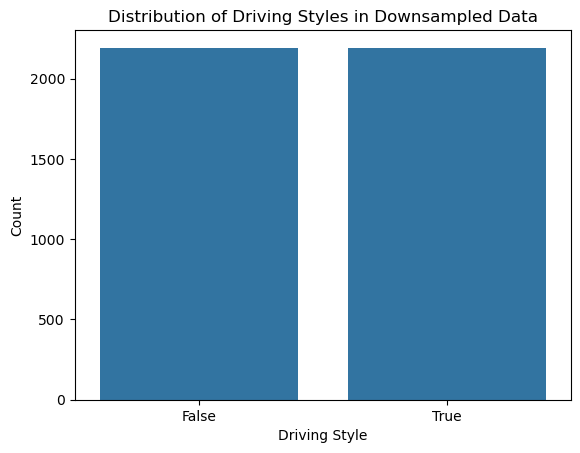

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the target variable in the downsampled training set to a DataFrame for visualization
y_train_downsampled_df = y_train_downsampled.to_frame()

# Plot the distribution of the target variable
sns.countplot(x='drivingStyle_EvenPaceStyle', data=y_train_downsampled_df)

# Set the title and labels for the plot
plt.title('Distribution of Driving Styles in Downsampled Data')
plt.xlabel('Driving Style')
plt.ylabel('Count')

# Show the plot
plt.show()


In [153]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the downsampled training data and transform it
X_train_scaled = scaler.fit_transform(X_train_downsampled)

# The test data should be scaled using the same scaler to ensure consistency
X_test_scaled = scaler.transform(X_test)  # Assuming X_test is your original test set

# Now, X_train_scaled and X_test_scaled are ready to be used for training and evaluating your models.


In [154]:
import numpy as np

# Check the mean and standard deviation of the scaled features
print("Mean of scaled features:", np.mean(X_train_scaled, axis=0))
print("Standard Deviation of scaled features:", np.std(X_train_scaled, axis=0))


Mean of scaled features: [ 2.59203916e-17  5.18407833e-17 -9.07213707e-17 -6.48009791e-17
  2.26803427e-17  3.24004895e-18 -5.18407833e-17 -1.87922839e-16
  1.36082056e-16  1.88732852e-16 -1.15021738e-16  2.59203916e-17
 -1.94402937e-17  1.42562154e-16  1.13401713e-17  0.00000000e+00
  7.77611749e-17 -1.29601958e-17 -3.88805875e-17  1.29601958e-16
 -2.59203916e-17  0.00000000e+00]
Standard Deviation of scaled features: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


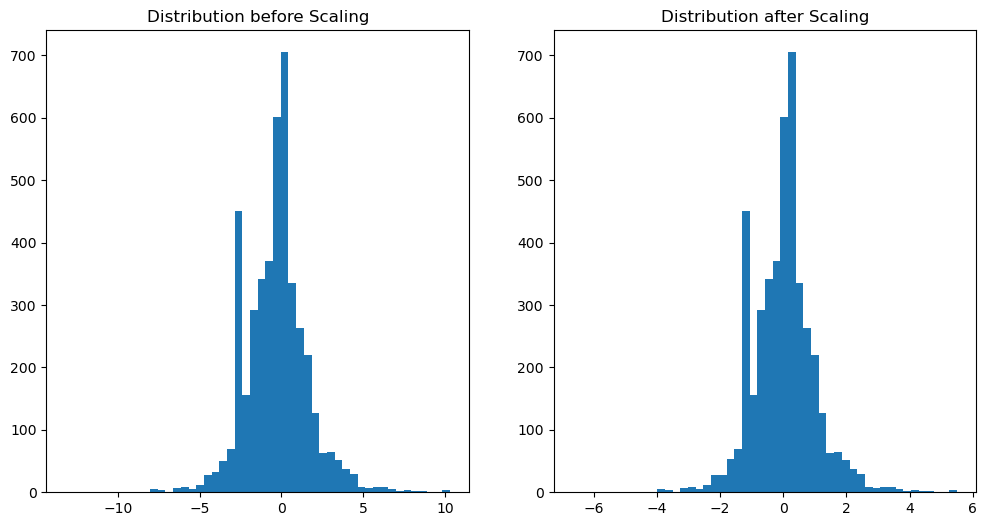

In [155]:
import matplotlib.pyplot as plt

feature_index = 0  # Change this index to explore other features

# Plot before scaling
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(X_train_downsampled.iloc[:, feature_index], bins=50)
plt.title('Distribution before Scaling')

# Plot after scaling
plt.subplot(1, 2, 2)
plt.hist(X_train_scaled[:, feature_index], bins=50)
plt.title('Distribution after Scaling')

plt.show()


In [156]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_downsampled)
X_test_scaled = scaler.transform(X_test)


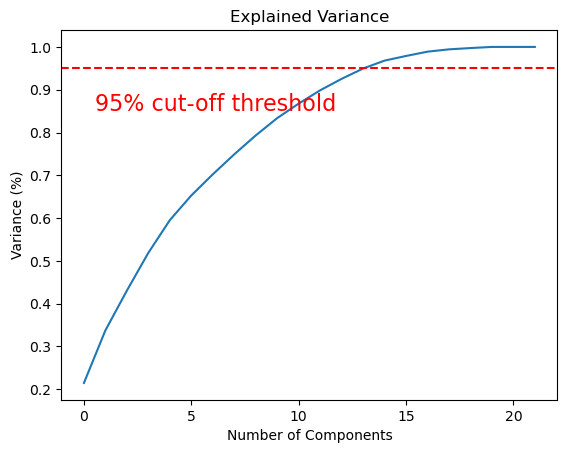

In [157]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA on the training set only
pca = PCA().fit(X_train_scaled)

# Plot the cumulative sum of eigenvalues (explained variance ratio)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.show()


In [159]:
from sklearn.decomposition import PCA

# Applying PCA with n_components as determined from the graph
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


training models

In [160]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Initialize classifiers
svm_model = SVC(kernel='linear')
logistic_model = LogisticRegression()
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train models on the PCA-transformed and downsampled training set
svm_model.fit(X_train_pca, y_train_downsampled)
logistic_model.fit(X_train_pca, y_train_downsampled)
knn_model.fit(X_train_pca, y_train_downsampled)


KNeighborsClassifier()

evaluate performace on test data

In [161]:
from sklearn.metrics import classification_report, accuracy_score

# SVM Evaluation
y_pred_svm = svm_model.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Logistic Regression Evaluation
y_pred_logistic = logistic_model.predict(X_test_pca)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Logistic Regression Accuracy: {accuracy_logistic}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# kNN Evaluation
y_pred_knn = knn_model.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"kNN Accuracy: {accuracy_knn}")
print("kNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


SVM Accuracy: 0.8630914826498423
SVM Classification Report:
              precision    recall  f1-score   support

       False       0.46      0.91      0.61       566
        True       0.99      0.86      0.92      4189

    accuracy                           0.86      4755
   macro avg       0.72      0.88      0.76      4755
weighted avg       0.92      0.86      0.88      4755

Logistic Regression Accuracy: 0.8605678233438486
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.46      0.90      0.61       566
        True       0.98      0.86      0.92      4189

    accuracy                           0.86      4755
   macro avg       0.72      0.88      0.76      4755
weighted avg       0.92      0.86      0.88      4755

kNN Accuracy: 0.9200841219768665
kNN Classification Report:
              precision    recall  f1-score   support

       False       0.60      0.98      0.74       566
        True       1.00  

In [162]:
from sklearn.model_selection import GridSearchCV

# Example for kNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],  # typically odd numbers
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', verbose=1)
knn_grid.fit(X_train_pca, y_train_downsampled)

# Now you can check the best parameters and the best score
print(f"Best parameters for kNN: {knn_grid.best_params_}")
print(f"Best score for kNN: {knn_grid.best_score_}")

# Example for SVM
svm_params = {
    'C': [0.1, 1, 10, 100],  # regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # kernel coefficient
    'kernel': ['rbf', 'linear']  # kernel type
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', verbose=1)
svm_grid.fit(X_train_pca, y_train_downsampled)

# Now you can check the best parameters and the best score
print(f"Best parameters for SVM: {svm_grid.best_params_}")
print(f"Best score for SVM: {svm_grid.best_score_}")

# Example for Logistic Regression
logistic_params = {
    'C': [0.1, 1, 10, 100],  # inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # algorithm to use for optimization
}

logistic_grid = GridSearchCV(LogisticRegression(), logistic_params, cv=5, scoring='accuracy', verbose=1)
logistic_grid.fit(X_train_pca, y_train_downsampled)

# Now you can check the best parameters and the best score
print(f"Best parameters for Logistic Regression: {logistic_grid.best_params_}")
print(f"Best score for Logistic Regression: {logistic_grid.best_score_}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for kNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best score for kNN: 0.951665051960634
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for SVM: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best score for SVM: 0.989967610641995
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Logistic Regression: {'C': 1, 'solver': 'newton-cg'}
Best score for Logistic Regression: 0.8761991465001572


In [163]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model with the best parameters
best_knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')

# Train on the entire PCA-transformed training set
best_knn.fit(X_train_pca, y_train_downsampled)


KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [164]:
from sklearn.svm import SVC

# Initialize the model with the best parameters
best_svm = SVC(C=100, gamma=0.1, kernel='rbf')

# Train on the entire PCA-transformed training set
best_svm.fit(X_train_pca, y_train_downsampled)


SVC(C=100, gamma=0.1)

In [165]:
from sklearn.linear_model import LogisticRegression

# Initialize the model with the best parameters
best_logistic = LogisticRegression(C=1, solver='newton-cg')

# Train on the entire PCA-transformed training set
best_logistic.fit(X_train_pca, y_train_downsampled)


LogisticRegression(C=1, solver='newton-cg')

In [166]:
# KNN Predictions
y_pred_knn = best_knn.predict(X_test_pca)

# SVM Predictions
y_pred_svm = best_svm.predict(X_test_pca)

# Logistic Regression Predictions
y_pred_logistic = best_logistic.predict(X_test_pca)


In [167]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Function to calculate and print metrics
def print_model_performance(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("\n")

# Evaluate KNN
print_model_performance(y_test, y_pred_knn, "KNN")

# Evaluate SVM
print_model_performance(y_test, y_pred_svm, "SVM")

# Evaluate Logistic Regression
print_model_performance(y_test, y_pred_logistic, "Logistic Regression")


Model: KNN
Accuracy: 0.9385909568874868
Precision: 0.9576945973888404
Recall: 0.9385909568874868
F1 Score: 0.9435091089776912
Confusion Matrix:
 [[ 556   10]
 [ 282 3907]]
Classification Report:
               precision    recall  f1-score   support

       False       0.66      0.98      0.79       566
        True       1.00      0.93      0.96      4189

    accuracy                           0.94      4755
   macro avg       0.83      0.96      0.88      4755
weighted avg       0.96      0.94      0.94      4755



Model: SVM
Accuracy: 0.9934805467928496
Precision: 0.9938190778639077
Recall: 0.9934805467928496
F1 Score: 0.9935553291355537
Confusion Matrix:
 [[ 566    0]
 [  31 4158]]
Classification Report:
               precision    recall  f1-score   support

       False       0.95      1.00      0.97       566
        True       1.00      0.99      1.00      4189

    accuracy                           0.99      4755
   macro avg       0.97      1.00      0.98      4755
weighte

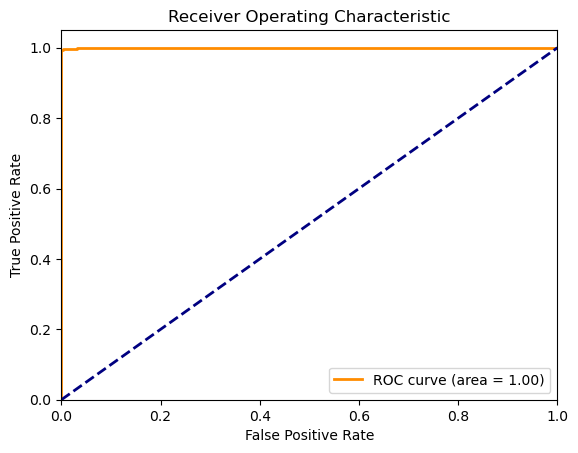

In [168]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_score = best_svm.decision_function(X_test_pca)  # Replace best_svm with your model variable

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


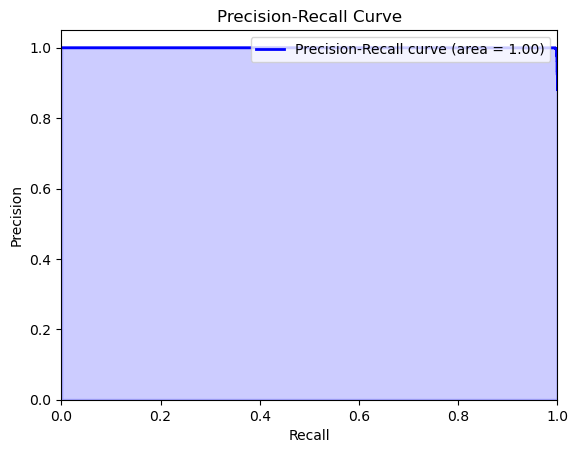

In [169]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay

# Predict probabilities for the positive class
y_score = best_svm.decision_function(X_test_pca)  # Use predict_proba for models that support it

# Compute Precision-Recall curve and area
precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure()
lw = 2  # Line width
plt.plot(recall, precision, color='blue', lw=lw, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.fill_between(recall, precision, alpha=0.2, color='blue', lw=lw)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


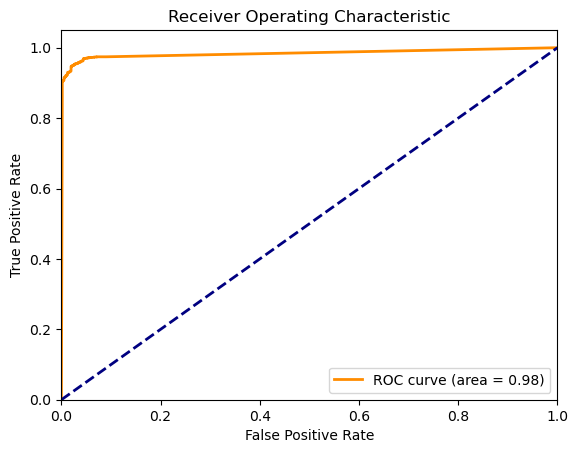

In [172]:
# Predict probabilities for the positive class
y_probabilities = best_knn.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


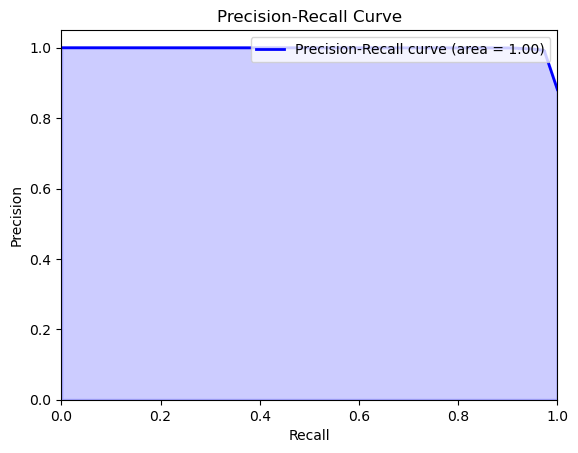

In [173]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay

# Predict probabilities for the positive class
y_probabilities = best_knn.predict_proba(X_test_pca)[:, 1]  # Only take the second column for positive class

# Compute Precision-Recall curve and area
precision, recall, _ = precision_recall_curve(y_test, y_probabilities)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure()
lw = 2  # Line width
plt.plot(recall, precision, color='blue', lw=lw, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.fill_between(recall, precision, alpha=0.2, color='blue', lw=lw)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


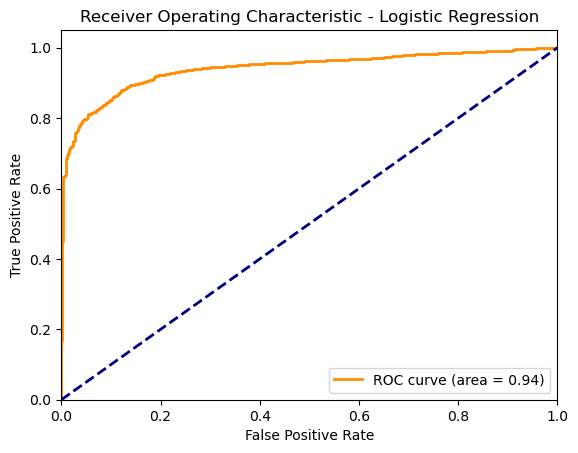

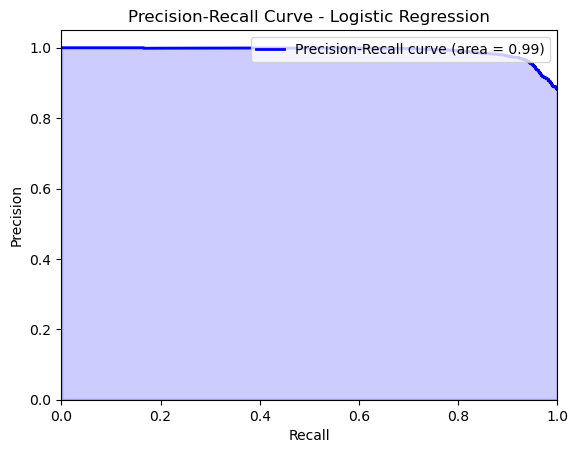

In [174]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# ROC AUC
# Predict probabilities for the positive class
y_score_logistic = best_logistic.decision_function(X_test_pca)

# Compute ROC curve and ROC area
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr_logistic, tpr_logistic, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
# Compute Precision-Recall curve and area
precision_logistic, recall_logistic, _ = precision_recall_curve(y_test, y_score_logistic)
pr_auc_logistic = auc(recall_logistic, precision_logistic)

# Plot Precision-Recall curve
plt.figure()
lw = 2  # Line width
plt.plot(recall_logistic, precision_logistic, color='blue',
         lw=lw, label='Precision-Recall curve (area = %0.2f)' % pr_auc_logistic)
plt.fill_between(recall_logistic, precision_logistic, alpha=0.2, color='blue', lw=lw)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc="upper right")
plt.show()
